In [215]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended
from sklearn.base import BaseEstimator, RegressorMixin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# 1. Boston Dataset

## 1.1 Data preprocessing

In [216]:
boston_origin = pd.read_csv('Boston.csv')

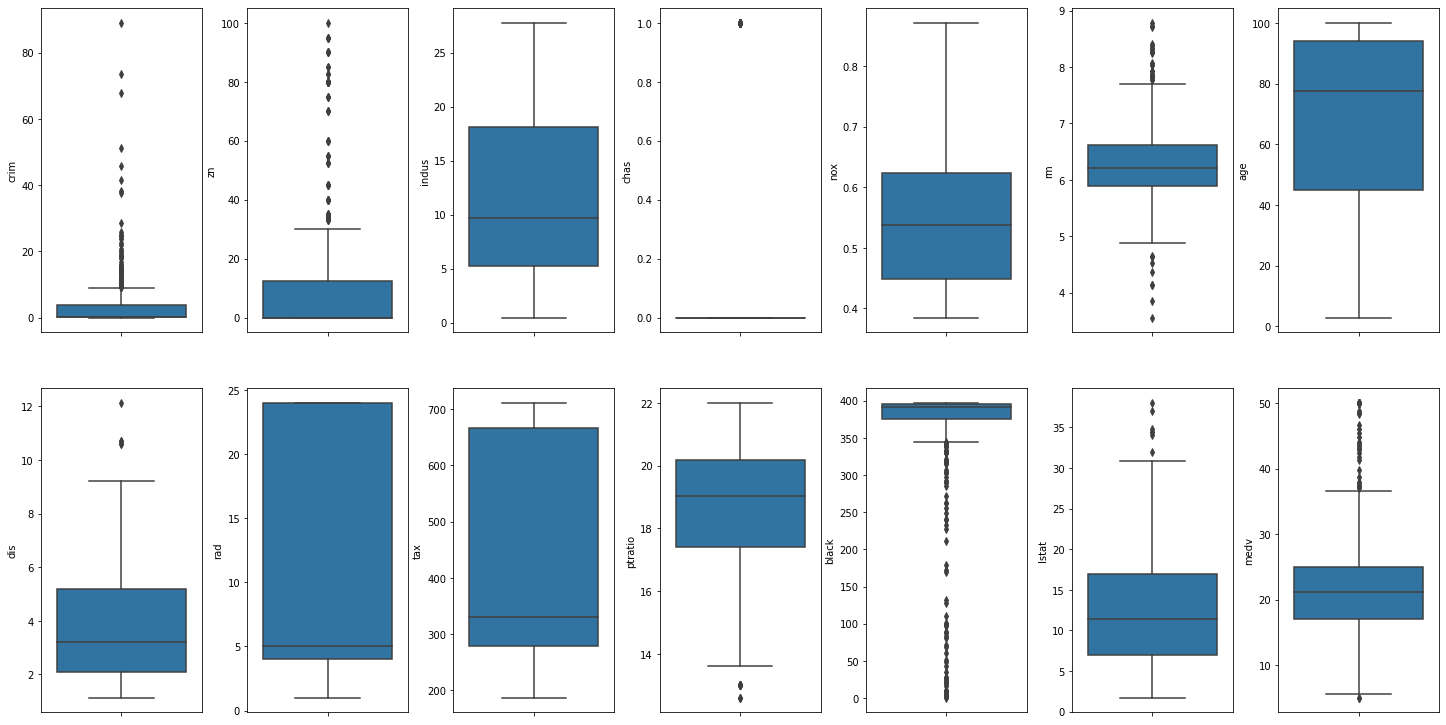

In [217]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in boston_origin.items():
    sns.boxplot(y=k, data=boston_origin, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [218]:
for k, v in boston_origin.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(boston_origin)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column crim outliers = 13.04%
Column zn outliers = 13.44%
Column indus outliers = 0.00%
Column chas outliers = 100.00%
Column nox outliers = 0.00%
Column rm outliers = 5.93%
Column age outliers = 0.00%
Column dis outliers = 0.99%
Column rad outliers = 0.00%
Column tax outliers = 0.00%
Column ptratio outliers = 2.96%
Column black outliers = 15.22%
Column lstat outliers = 1.38%
Column medv outliers = 7.91%


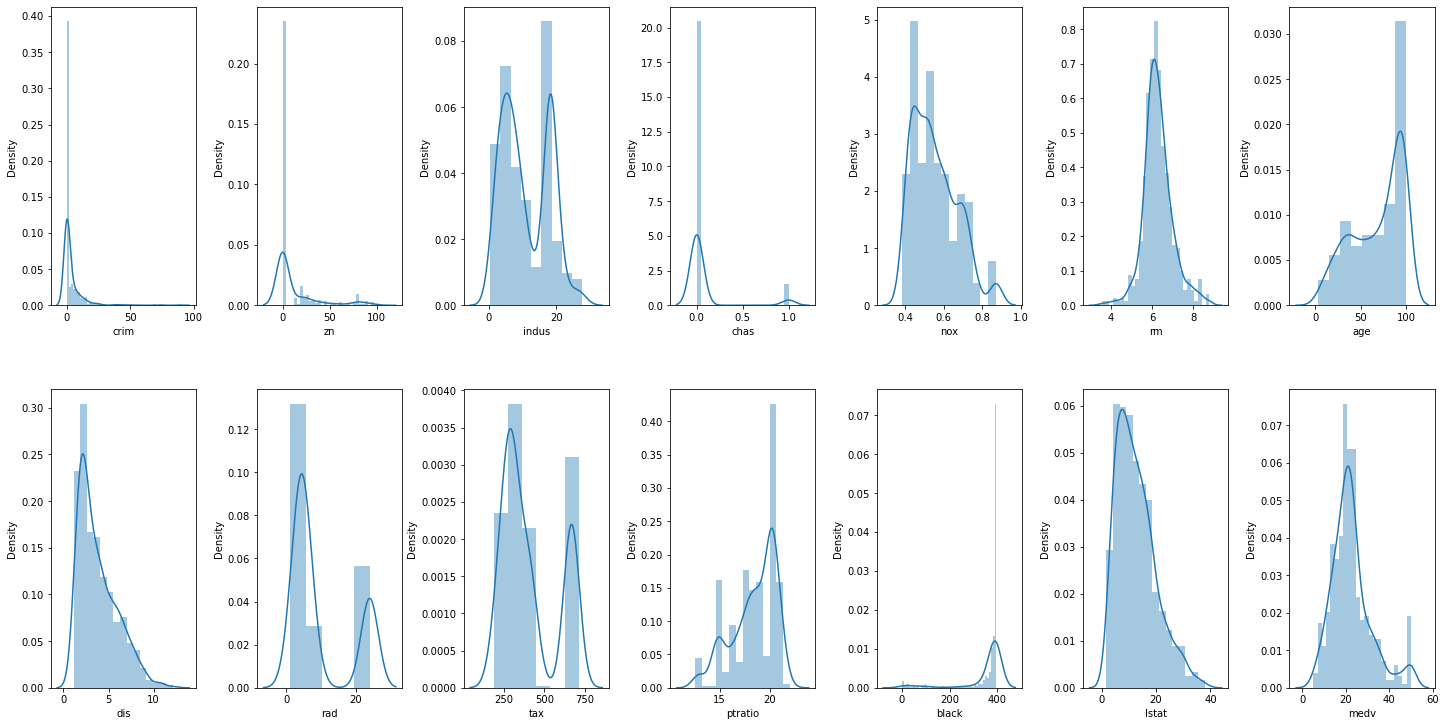

In [219]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in boston_origin.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [220]:
boston_origin.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [221]:
def data_preprocessing(boston_origin):
    """
    Divide dataset into traning dataset and testing dataset. The training dataset will be futher 
    used in validation process.
    X, y are training data, X_test and y_test are testing data.
    """
    boston_new = boston_origin
    indices_tr, indices_test = train_test_split([i for i in range(boston_new.shape[0])], test_size = 0.2, random_state = 1)

    df = boston_new.iloc[indices_tr,:]
    df_test = boston_new.iloc[indices_test,:]

    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    X_test = df_test.iloc[:,1:]
    y_test = df_test.iloc[:,0]
    
    return X, y, X_test, y_test

In [222]:
class LR(BaseEstimator, RegressorMixin):
    """
    A sklearn wrapper for statsmodels regressors.
    For supporting stats report in statsmodel and pipeline in sklearn.
    """
    def __init__(self, model_class=sm.OLS, fit_intercept=True):
        super(LR, self).__init__()
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        self.params = self.results_.params
        
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    
    def summary(self):
        """Print the Linear Regression report"""
        print(self.results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [223]:
# Normalization
boston_origin = boston_origin[boston_origin['crim'] < 20]  # Remove the outliers
scalar = StandardScaler(copy=True)
sel_train_boston = pd.DataFrame(scalar.fit_transform(boston_origin))

In [224]:
# Divide X,y,X_test,y_test
X, y, X_test, y_test = data_preprocessing(sel_train_boston)

## 1.2 Linear Regression

In [225]:
# Evaluate LR using 5 fold validation
model_linear = LinearRegression()
scores = cross_val_score(model_linear, X, y, cv = 5, scoring='neg_mean_squared_error')
print(-scores)
print('MSE: %.4f, STD: %.2f'%(-scores.mean(), scores.std()))
model_linear.fit(X,y)

# Show the MSE on test dataset
preds = model_linear.predict(X_test)
print('MSE on test dataset: ', metrics.mean_squared_error(preds, y_test))

[0.29463863 0.2669874  0.28059205 0.16461099 0.17406436]
MSE: 0.2362, STD: 0.06
MSE on test dataset:  0.23900116471366206


In [226]:
# Show the OLS Regression Results report
X_train_lr = X
X_test = X_test
y_train_lr = y
y_test = y_test
ols = LR()
results_lr = ols.fit(X_train_lr,y_train_lr)
pred_lr = ols.predict(X_test)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_lr, y_test))
results_lr.summary()

MSE on test dataset:  0.23900116471366215
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     106.8
Date:                Sat, 17 Jul 2021   Prob (F-statistic):          1.88e-117
Time:                        05:08:24   Log-Likelihood:                -247.51
No. Observations:                 390   AIC:                             523.0
Df Residuals:                     376   BIC:                             578.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

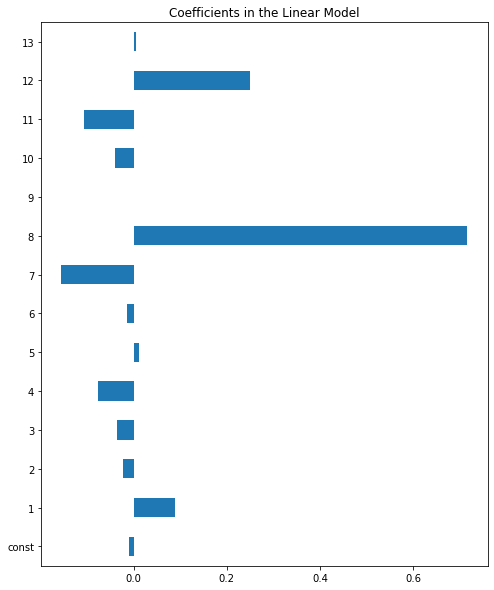

Sum of coefficients: 1.5293041440195179
Sum square of coefficients: 0.6282242030102312


In [16]:
# Coefficients visulization
coef = pd.Series(ols.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()

print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_lr.params)), sum(map(lambda x:x*x,results_lr.params))
))

## 1.3 Lasso

In [20]:
class LR_Lasso(BaseEstimator, RegressorMixin):
    """
    A sklearn wrapper for statsmodels regressors.
    For supporting stats report in statsmodel and pipeline in sklearn.
    """
    
    def __init__(self, model_class=sm.OLS, alpha = 0, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', L1_wt=1, alpha=self.alpha)
        pinv_wexog,_ = pinv_extended(self.model_.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        self.final_results_ = sm.regression.linear_model.OLSResults(self.model_, 
                                  self.results_.params, 
                                  normalized_cov_params)
        self.params = self.results_.params
       
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)

        return self.results_.predict(X)
    
    def print_params(self):
        print(self.normalized_cov_params)
        
    def summary(self):
        """Print the Linear Regression report"""
        print(self.final_results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [21]:
alpha = [1, .1, .01, .001, .0001]
param_grid = {'model_lasso__alpha': alpha}

model_lasso = LR_Lasso()

pipeline = Pipeline([('model_lasso', model_lasso)])
gd=GridSearchCV(pipeline,param_grid,verbose=True, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
gd.fit(X,y)

print(-gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.23510449700388678
Pipeline(steps=[('model_lasso', LR_Lasso(alpha=0.001))])


In [22]:
# Apply model on traning dataset
# Apply on test dataset
# alpha manualy selected as 0.01

scalar_lasso = StandardScaler()

X_train_lasso = scalar_lasso.fit_transform(X)
X_test_lasso = scalar_lasso.transform(X_test)
y_train_lasso = y

model_lasso = LR_Lasso(alpha=0.001)

results_lasso = model_lasso.fit(X_train_lasso,y_train_lasso)
pred_lasso = model_lasso.predict(X_test_lasso)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_lasso, y_test))
results_lasso.summary()

MSE on test dataset:  0.2378114422048976
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     106.8
Date:                Sat, 17 Jul 2021   Prob (F-statistic):          1.95e-117
Time:                        03:02:11   Log-Likelihood:                -247.55
No. Observations:                 390   AIC:                             523.1
Df Residuals:                     376   BIC:                             578.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

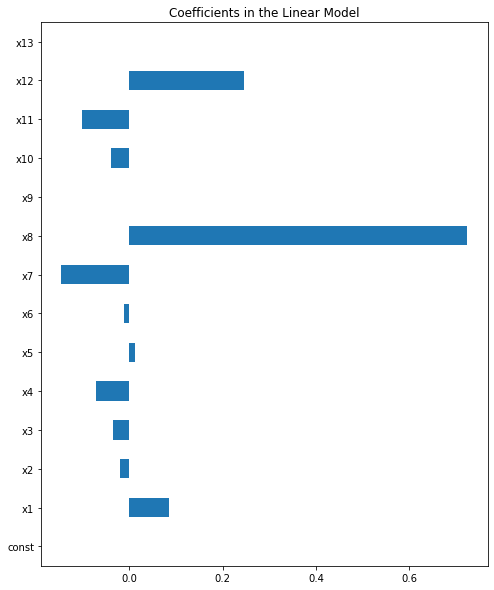

Sum of coefficients: 0.6475840982451885
Sum square of coefficients: 0.6320561937024212


In [23]:
coef = pd.Series(results_lasso.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_lr.params)), sum(map(lambda x:x*x,results_lr.params))
))


## 1.4 Ridge

In [24]:
class LR_Ridge(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class=sm.OLS, L1_wt=0, alpha=0, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        self.L1_wt = L1_wt
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', L1_wt=0, alpha=self.alpha)
        pinv_wexog,_ = pinv_extended(self.model_.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        self.final_results_ = sm.regression.linear_model.OLSResults(self.model_, 
                                  self.results_.params, 
                                  normalized_cov_params)
        
        self.params = self.results_.params
       
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)

        return self.results_.predict(X)
    
    def print_params(self):
        print(self.normalized_cov_params)
        
    def summary(self):
        """Print the Linear Regression report"""
        print(self.final_results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [25]:
alpha = [1, .1, .01, .001, .0001]
param_grid = {'model_ridge__alpha': alpha}

model_ridge = LR_Ridge()

pipeline = Pipeline([('model_ridge', model_ridge)])
gd=GridSearchCV(pipeline,param_grid,verbose=True, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gd.fit(X,y)

print(-gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.2356700613663484
Pipeline(steps=[('model_ridge', LR_Ridge(alpha=0.01))])


In [26]:
# Apply model on traning dataset
# Apply on test dataset
# alpha manualy selected as 0.01

scalar_ridge = MinMaxScaler()
model_ridge = LR_Ridge(alpha=0.01)



X_train_ridge = scalar_ridge.fit_transform(X)
X_test_ridge = scalar_ridge.transform(X_test)
y_train_ridge = y

results_ridge = model_ridge.fit(X_train_ridge,y_train_ridge)
pred_ridge = model_ridge.predict(X_test_ridge)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_ridge, y_test))
results_ridge.summary()

MSE on test dataset:  0.24289901119971624
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     99.91
Date:                Sat, 17 Jul 2021   Prob (F-statistic):          3.28e-113
Time:                        03:04:10   Log-Likelihood:                -257.72
No. Observations:                 390   AIC:                             543.4
Df Residuals:                     376   BIC:                             599.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

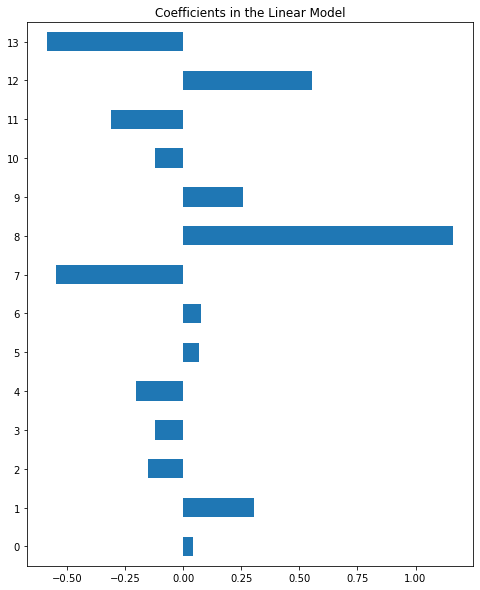

Sum of coefficients: 0.4231640366577549
Sum square of coefficients: 2.6572265521510663


In [21]:
coef = pd.Series(results_ridge.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_lr.params)), sum(map(lambda x:x*x,results_lr.params))
))


## 1.5 Elastic Net

In [27]:
class LR_Elastic_Net(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class=sm.OLS, L1_wt=0.5, alpha = 0, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        self.L1_wt = L1_wt
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', L1_wt=0.5, alpha=self.alpha)
        pinv_wexog,_ = pinv_extended(self.model_.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        self.final_results_ = sm.regression.linear_model.OLSResults(self.model_, 
                                  self.results_.params, 
                                  normalized_cov_params)
        
        self.params = self.results_.params
        
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)

        return self.results_.predict(X)
    
    def print_params(self):
        print(self.normalized_cov_params)
        
    def summary(self):
        """Print the Linear Regression report"""
        print(self.final_results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [28]:
alpha = [1, .1, .01, .001, .0001]
L1_wt = [i/10 for i in range(1,10)]
param_grid = {
    'model_en__alpha': alpha,
    'model_en__L1_wt': L1_wt
}

model_en = LR_Elastic_Net()

pipeline = Pipeline([('model_en', model_en)])
gd=GridSearchCV(pipeline,param_grid,verbose=True, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gd.fit(X,y)

print(-gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
0.23353417795548098
Pipeline(steps=[('model_en', LR_Elastic_Net(L1_wt=0.1, alpha=0.01))])


In [29]:
# Apply model on traning dataset
# Apply on test dataset
# L1_wt=0.1,alpha=0.001

scalar_en = StandardScaler()

X_train_en = scalar_en.fit_transform(X)
X_test_en = scalar_en.transform(X_test)
y_train_en = y

model_en = LR_Elastic_Net(L1_wt=0.1, alpha=0.01)

results_en = model_en.fit(X_train_en,y_train_en)
pred_en = model_en.predict(X_test_en)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_en, y_test))
results_en.summary()

MSE on test dataset:  0.2406992147327512
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     103.0
Date:                Sat, 17 Jul 2021   Prob (F-statistic):          4.02e-115
Time:                        03:04:56   Log-Likelihood:                -253.12
No. Observations:                 390   AIC:                             534.2
Df Residuals:                     376   BIC:                             589.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

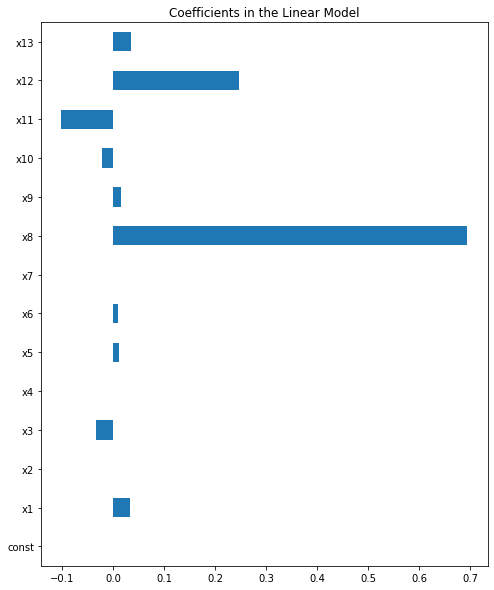

Sum of coefficients: 1.5293041440195179
Sum square of coefficients: 0.6282242030102312


In [30]:
coef = pd.Series(results_en.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_lr.params)), sum(map(lambda x:x*x,results_lr.params))
))

# 2. House Price Dataset

## 2.1 Data Screening

In [77]:
# check missingValue
def missingValueCorre(data,col):
    total = data.isna().sum().sort_values(ascending=False)
    percent = round(total/len(data), 4)
    coln = col

    missing = pd.concat([total, percent], axis=1)
    missing.columns = ['total', 'percentage']

    # let's also see corresponding correlation values
    corrmat = data.corr()
    corr_tmp = corrmat[coln]
    corr_tmp.name = 'corefficient'
    missingcorr = missing.merge(corr_tmp, how='outer', left_index=True, right_index=True).sort_values(by='percentage', ascending=False)
    return missingcorr

In [78]:
# correlationship hot matrix
def corrHotMatrix(data,threshold):
    corrmat = data.corr()
    highcorr = corrmat.SalePrice.sort_values(ascending=False)
    
    # Pick correlation values that are > threshold
    highcorr = highcorr[highcorr > threshold]
    
    highcorrmat = corrmat.loc[highcorr.index, highcorr.index]
    
    # Correlation heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(highcorrmat, annot=True, fmt='.2f')
    plt.show()
    
    return plt.show(),highcorrmat

In [79]:
# normalization detection
def normalDetect(data,col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    sns.distplot(data[col], kde=True, fit=norm, ax=ax1)
    _ = stats.probplot(data[col], plot = ax2)
    fig.tight_layout()
    plt.show()

In [140]:
# path processing to extract filename--------def?
currentRoot = os.getcwd()
dataRoot = currentRoot
os.chdir(dataRoot)
fileNameFrame = os.listdir(os.getcwd())
num = len('csv')
fileNameTrain = fileNameFrame[-3][:-(num+1)]

In [170]:
#Loading data
train_df = pd.read_csv("house_price_train.csv")

In [171]:
# Generating Nan and correfficient matrix
missingcorr = missingValueCorre(train_df,'SalePrice')
missingcorr.head(40)

total  percentage  corefficient
PoolQC         1453      0.9952           NaN
MiscFeature    1406      0.9630           NaN
Alley          1369      0.9377           NaN
Fence          1179      0.8075           NaN
FireplaceQu     690      0.4726           NaN
LotFrontage     259      0.1774      0.351799
GarageFinish     81      0.0555           NaN
GarageQual       81      0.0555           NaN
GarageType       81      0.0555           NaN
GarageYrBlt      81      0.0555      0.486362
GarageCond       81      0.0555           NaN
BsmtExposure     38      0.0260           NaN
BsmtFinType2     38      0.0260           NaN
BsmtQual         37      0.0253           NaN
BsmtCond         37      0.0253           NaN
BsmtFinType1     37      0.0253           NaN
MasVnrType        8      0.0055           NaN
MasVnrArea        8      0.0055      0.477493
Electrical        1      0.0007           NaN
MiscVal           0      0.0000     -0.021190
MoSold            0      0.0000      0.046432
1stFlrSF          0      0.0000      0.605852
OpenPorchSF       0      0.0000      0.315856
MSZoning          0      0.0000           NaN
MSSubClass        0      0.0000     -0.084284
LowQualFinSF      0      0.0000     -0.025606
LotShape          0      0.0000           NaN
Neighborhood      0      0.0000           NaN
PoolArea          0      0.0000      0.092404
OverallCond       0      0.0000     -0.077856
OverallQual       0      0.0000      0.790982
YearRemodAdd      0      0.0000      0.507101
YearBuilt         0      0.0000      0.522897
WoodDeckSF        0      0.0000      0.324413
Utilities         0      0.0000           NaN
TotalBsmtSF       0      0.0000      0.613581
TotRmsAbvGrd      0      0.0000      0.533723
Street            0      0.0000           NaN
ScreenPorch       0      0.0000      0.111447
SaleType          0      0.0000           NaN

## 2.2 Data Preparation

In [187]:
# Dropping columns
del_cols = missingcorr[missingcorr['percentage'] > missingcorr.loc['Electrical', 'percentage']].index
del_cols
print("Initial data shape:", train_df.shape)

# The train_nona refers to train data without NaN values
sel_train = train_df.drop(columns=del_cols)
print("After dropping columns:", sel_train.shape)

sel_train = sel_train.dropna(axis=0, how='any')
print("After dropping instance of Electrical: ", sel_train.shape)
print("Total missing values in data after cleaning: ", sel_train.isna().sum().sum())

Initial data shape: (1460, 81)
After dropping columns: (1460, 63)
After dropping instance of Electrical:  (1459, 63)
Total missing values in data after cleaning:  0


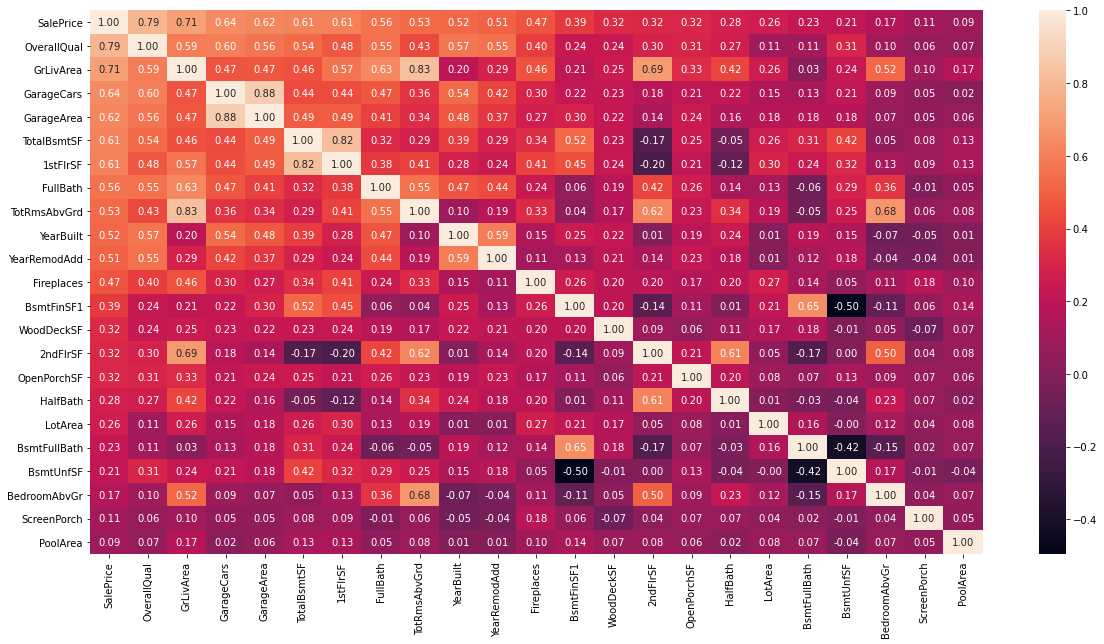

In [188]:
# check hot matrix
hotMatrix, highcorrmat = corrHotMatrix(sel_train,0.05)

In [189]:
# check features' info
features = highcorrmat.columns
sel_train = sel_train[features]
print("Selected train data shape:", sel_train.shape)
sel_train.info()
sel_train.head(100)

Selected train data shape: (1459, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     1459 non-null   int64
 1   OverallQual   1459 non-null   int64
 2   GrLivArea     1459 non-null   int64
 3   GarageCars    1459 non-null   int64
 4   GarageArea    1459 non-null   int64
 5   TotalBsmtSF   1459 non-null   int64
 6   1stFlrSF      1459 non-null   int64
 7   FullBath      1459 non-null   int64
 8   TotRmsAbvGrd  1459 non-null   int64
 9   YearBuilt     1459 non-null   int64
 10  YearRemodAdd  1459 non-null   int64
 11  Fireplaces    1459 non-null   int64
 12  BsmtFinSF1    1459 non-null   int64
 13  WoodDeckSF    1459 non-null   int64
 14  2ndFlrSF      1459 non-null   int64
 15  OpenPorchSF   1459 non-null   int64
 16  HalfBath      1459 non-null   int64
 17  LotArea       1459 non-null   int64
 18  BsmtFullBath  1459 non-null   

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0      208500            7       1710           2         548          856   
1      181500            6       1262           2         460         1262   
2      223500            7       1786           2         608          920   
3      140000            7       1717           3         642          756   
4      250000            8       2198           3         836         1145   
..        ...          ...        ...         ...         ...          ...   
95     185000            6       1470           2         420          680   
96     214000            7       1588           2         472         1588   
97      94750            4        960           1         432          960   
98      83000            5        835           1         366          458   
99     128950            4       1225           0           0          950   

    1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  ...  WoodDeckSF  2ndFlrSF  \
0        856         2             8       2003  ...           0       854   
1       1262         2             6       1976  ...         298         0   
2        920         2             6       2001  ...           0       866   
3        961         1             7       1915  ...           0       756   
4       1145         2             9       2000  ...         192      1053   
..       ...       ...           ...        ...  ...         ...       ...   
95       680         2             6       1993  ...         232       790   
96      1588         2             6       1999  ...         158         0   
97       960         1             6       1965  ...         120         0   
98       835         1             5       1920  ...           0         0   
99      1225         1             6       1959  ...         352         0   

    OpenPorchSF  HalfBath  LotArea  BsmtFullBath  BsmtUnfSF  BedroomAbvGr  \
0            61         1     8450             1        150             3   
1             0         0     9600             0        284             3   
2            42         1    11250             1        434             3   
3            35         0     9550             1        540             3   
4            84         1    14260             1        490             4   
..          ...       ...      ...           ...        ...           ...   
95           63         1     9765             0        370             3   
96           29         0    10264             0        426             3   
97            0         0    10921             1        440             3   
98            0         0    10625             0        350             2   
99            0         1     9320             1        381             3   

    ScreenPorch  PoolArea  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
..          ...       ...  
95            0         0  
96            0         0  
97            0         0  
98            0         0  
99            0         0  

[100 rows x 23 columns]

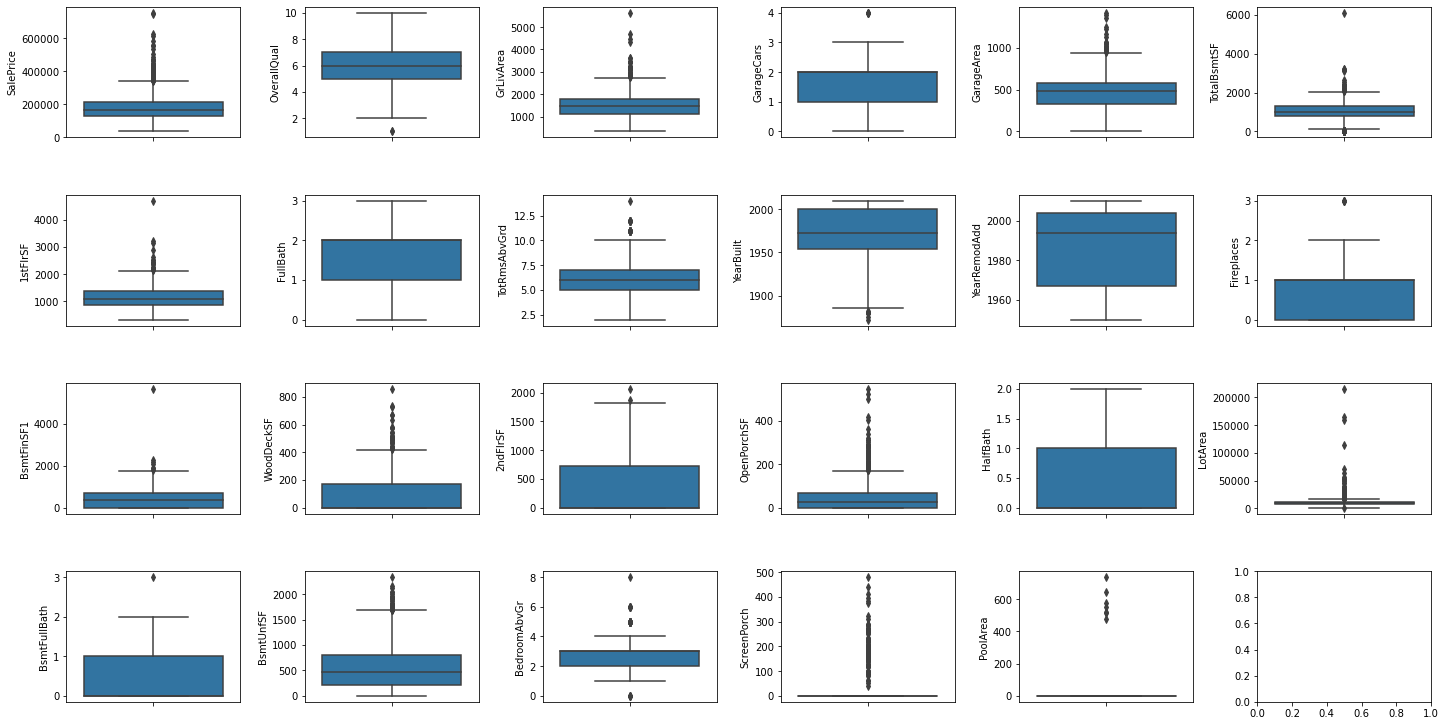

In [190]:
fig, axs = plt.subplots(ncols=6, nrows=4, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in sel_train.items():
    sns.boxplot(y=k, data=sel_train, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [191]:
# Normalization, mean =0, std =1
sel_train = sel_train[sel_train['SalePrice'] < 380000]  # Remove the outliers

sel_train.head(10)

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0     208500            7       1710           2         548          856   
1     181500            6       1262           2         460         1262   
2     223500            7       1786           2         608          920   
3     140000            7       1717           3         642          756   
4     250000            8       2198           3         836         1145   
5     143000            5       1362           2         480          796   
6     307000            8       1694           2         636         1686   
7     200000            7       2090           2         484         1107   
8     129900            7       1774           2         468          952   
9     118000            5       1077           1         205          991   

   1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  ...  WoodDeckSF  2ndFlrSF  \
0       856         2             8       2003  ...           0       854   
1      1262         2             6       1976  ...         298         0   
2       920         2             6       2001  ...           0       866   
3       961         1             7       1915  ...           0       756   
4      1145         2             9       2000  ...         192      1053   
5       796         1             5       1993  ...          40       566   
6      1694         2             7       2004  ...         255         0   
7      1107         2             7       1973  ...         235       983   
8      1022         2             8       1931  ...          90       752   
9      1077         1             5       1939  ...           0         0   

   OpenPorchSF  HalfBath  LotArea  BsmtFullBath  BsmtUnfSF  BedroomAbvGr  \
0           61         1     8450             1        150             3   
1            0         0     9600             0        284             3   
2           42         1    11250             1        434             3   
3           35         0     9550             1        540             3   
4           84         1    14260             1        490             4   
5           30         1    14115             1         64             1   
6           57         0    10084             1        317             3   
7          204         1    10382             1        216             3   
8            0         0     6120             0        952             2   
9            4         0     7420             1        140             2   

   ScreenPorch  PoolArea  
0            0         0  
1            0         0  
2            0         0  
3            0         0  
4            0         0  
5            0         0  
6            0         0  
7            0         0  
8            0         0  
9            0         0  

[10 rows x 23 columns]

In [192]:
scalar = StandardScaler(copy=True)
sel_train_house = pd.DataFrame(scalar.fit_transform(sel_train))

In [193]:
def data_preprocessing(boston_origin):
    """
    Divide dataset into traning dataset and testing dataset. The training dataset will be futher 
    used in validation process.
    X, y are training data, X_test and y_test are testing data.
    """
    boston_new = boston_origin
    indices_tr, indices_test = train_test_split([i for i in range(boston_new.shape[0])], test_size = 0.2, random_state = 1)

    df = boston_new.iloc[indices_tr,:]
    df_test = boston_new.iloc[indices_test,:]

    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    X_test = df_test.iloc[:,1:]
    y_test = df_test.iloc[:,0]
    
    return X, y, X_test, y_test

In [194]:
class LR(BaseEstimator, RegressorMixin):
    """
    A sklearn wrapper for statsmodels regressors.
    For supporting stats report in statsmodel and pipeline in sklearn.
    """
    def __init__(self, model_class=sm.OLS, fit_intercept=True):
        super(LR, self).__init__()
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        self.params = self.results_.params
        
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    def summary(self):
        print(self.results_.summary())
        
    def params(self):
        return self.params

In [195]:
# Divide train-test sets
X, y, X_test, y_test = data_preprocessing(sel_train_house)

## 2.3 Linear Regression

In [196]:
# install LR
model_linear = LR()
scores = cross_val_score(model_linear, X, y, cv = 5, scoring='neg_mean_squared_error')
print(-scores)
print('MSE: %.4f, STD: %.4f'%(-scores.mean(), scores.std()))
model_linear.fit(X,y)
preds = model_linear.predict(X_test)
print('MSE on test dataset: ', metrics.mean_squared_error(preds, y_test))

[0.75232896 0.1622322  0.23966211 0.15452282 0.13741182 0.15236145
 0.28013062 0.15253579 0.22420167 0.20145647]
MSE: 0.2457, STD: 0.1746
MSE on test dataset:  0.15443839273597662


In [212]:
# Show the OLS Regression Results report

X_train_lr = X
y_train_lr = y

results_lr = model_linear.fit(X_train_lr,y_train_lr)
results_lr.summary()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.804
Model:                            OLS   Adj. R-squared (uncentered):              0.800
Method:                 Least Squares   F-statistic:                              208.0
Date:                Sat, 17 Jul 2021   Prob (F-statistic):                        0.00
Time:                        04:23:40   Log-Likelihood:                         -692.11
No. Observations:                1135   AIC:                                      1428.
Df Residuals:                    1113   BIC:                                      1539.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

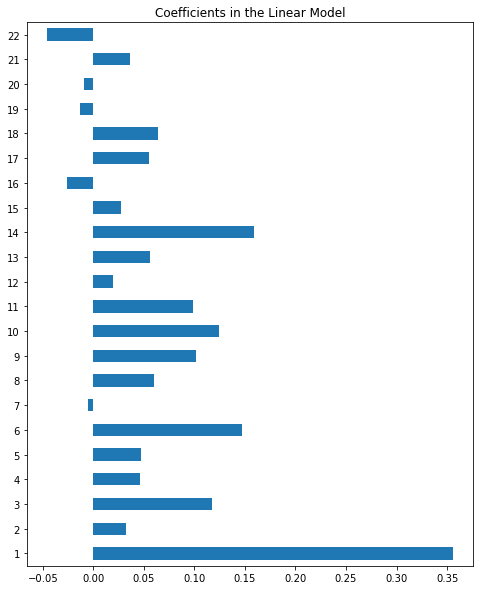

Sum of coefficients: 1.6470558341546657
Sum square of coefficients: 0.24729998742707057


In [213]:
# Coefficients visulization
coef = pd.Series(results_lr.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()

print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_lr.params)), sum(map(lambda x:x*x,results_lr.params))
))


## 2.4 Lasso

In [199]:
class LR_Lasso(BaseEstimator, RegressorMixin):
    """
    A sklearn wrapper for statsmodels regressors.
    For supporting stats report in statsmodel and pipeline in sklearn.
    In lasso, L1_wt =1
    """
    
    def __init__(self, model_class=sm.OLS, alpha = 0, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        
    def fit(self, X, y):
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', L1_wt=1, alpha=self.alpha)
        pinv_wexog,_ = pinv_extended(self.model_.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        self.final_results_ = sm.regression.linear_model.OLSResults(self.model_, 
                                  self.results_.params, 
                                  normalized_cov_params)
        self.params = self.results_.params
       
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    def print_params(self):
        print(self.normalized_cov_params)
        
    def summary(self):
        """Print the Linear Regression report"""
        print(self.final_results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [200]:
# GridSearch 
alpha = [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
param_grid = {'model_lasso__alpha': alpha}

model_lasso = LR_Lasso()

pipeline = Pipeline([('model_lasso', model_lasso)])
gd=GridSearchCV(pipeline,param_grid,verbose=True, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
gd.fit(X,y)

print(-gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
0.23473541645676352
Pipeline(steps=[('model_lasso', LR_Lasso(alpha=0.03))])


In [201]:
# Apply model on traning dataset
# Apply on test dataset
# alpha manualy selected as 0.01

X_train_lasso = X
X_train_lasso = X_test
y_train_lasso = y

model_lasso = LR_Lasso(alpha=0.03)

results_lasso = model_lasso.fit(X_train_lasso,y_train_lasso)
pred_lasso = model_lasso.predict(X_test_lasso)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_lasso, y_test))
results_lasso.summary()

MSE on test dataset:  0.16708259187243632
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.797
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              198.3
Date:                Sat, 17 Jul 2021   Prob (F-statistic):                        0.00
Time:                        04:14:20   Log-Likelihood:                         -713.84
No. Observations:                1135   AIC:                                      1472.
Df Residuals:                    1113   BIC:                                      1582.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]

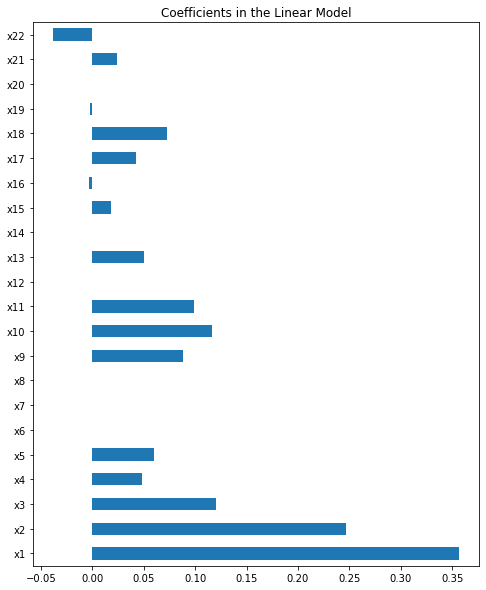

Sum of coefficients: 1.3869750600479427
Sum square of coefficients: 0.2516028982474544


In [158]:
coef = pd.Series(results_lasso.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_lasso.params)), sum(map(lambda x:x*x,results_lasso.params))
))


## 2.4 Ridge

In [159]:
class LR_Ridge(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors 
        In lasso, L1_wt =0, use L2"""
    def __init__(self, model_class=sm.OLS, L1_wt=0, alpha=0, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        self.L1_wt = L1_wt
        
    def fit(self, X, y):
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', L1_wt=0, alpha=self.alpha)
        pinv_wexog,_ = pinv_extended(self.model_.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        self.final_results_ = sm.regression.linear_model.OLSResults(self.model_, 
                                  self.results_.params, 
                                  normalized_cov_params)
        
        self.params = self.results_.params
       
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    def print_params(self):
        print(self.normalized_cov_params)
    
    def summary(self):
        """Print the Linear Regression report"""
        print(self.final_results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [160]:
alpha = [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
param_grid = {'model_ridge__alpha': alpha}

model_ridge = LR_Ridge()

pipeline = Pipeline([('model_ridge', model_ridge)])
gd=GridSearchCV(pipeline,param_grid,verbose=True, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gd.fit(X,y)

print(-gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
0.23399690984434254
Pipeline(steps=[('model_ridge', LR_Ridge(alpha=0.3))])


In [161]:
# Apply model on traning dataset
# Apply on test dataset
# alpha manualy selected as 0.1

model_ridge = LR_Ridge(alpha=0.3)

X_train_ridge = X
X_test_ridge = X_test
y_train_ridge = y

results_ridge = model_ridge.fit(X_train_ridge,y_train_ridge)
pred_ridge = model_ridge.predict(X_test_ridge)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_ridge, y_test))
results_ridge.summary()

MSE on test dataset:  0.15275352936575617
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                              205.3
Date:                Sat, 17 Jul 2021   Prob (F-statistic):                        0.00
Time:                        03:56:59   Log-Likelihood:                         -698.11
No. Observations:                1135   AIC:                                      1440.
Df Residuals:                    1113   BIC:                                      1551.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]

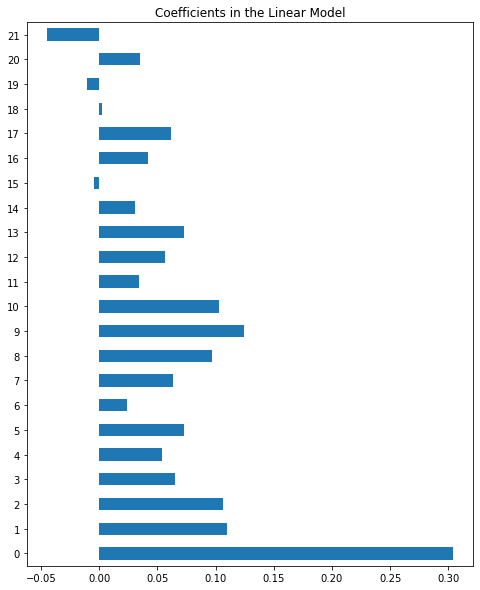

Sum of coefficients: 1.5167701192789762
Sum square of coefficients: 0.18765360601883901


In [162]:
coef = pd.Series(results_ridge.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_ridge.params)), sum(map(lambda x:x*x,results_ridge.params))
))


## 2.5 Elastic Net

In [207]:
class LR_Elastic_Net(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class=sm.OLS, L1_wt=0.5, alpha = 0, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        self.L1_wt = L1_wt
    def fit(self, X, y):
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(method='elastic_net', L1_wt=0.5, alpha=self.alpha)
        pinv_wexog,_ = pinv_extended(self.model_.wexog)
        normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
        self.final_results_ = sm.regression.linear_model.OLSResults(self.model_, 
                                  self.results_.params, 
                                  normalized_cov_params)
        
        self.params = self.results_.params
        
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    def print_params(self):
        print(self.normalized_cov_params)
        
    def summary(self):
        """Print the Linear Regression report"""
        print(self.final_results_.summary())
        
    def params(self):
        """Return the coefficients"""
        return self.params

In [208]:
alpha = [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
L1_wt = [i for i in range(1,10)]

param_grid = {
    'model_en__alpha': alpha,
    'model_en__L1_wt': L1_wt
}

model_en = LR_Elastic_Net()

pipeline = Pipeline([('model_en', model_en)])
gd=GridSearchCV(pipeline,param_grid,verbose=True, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gd.fit(X,y)

print(-gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 189 candidates, totalling 945 fits
0.2319082410926132
Pipeline(steps=[('model_en', LR_Elastic_Net(L1_wt=1, alpha=0.05))])


In [209]:
# Apply model on traning dataset
# Apply on test dataset
# L1_wt=0.1,alpha=0.1

X_train_en = X
X_test_en = X_test
y_train_en = y

model_en = LR_Elastic_Net(L1_wt=0.89, alpha=0.05)

results_en = model_en.fit(X_train_en,y_train_en)
pred_en = model_en.predict(X_test_en)
print('MSE on test dataset: ', metrics.mean_squared_error(pred_en, y_test))
results_en.summary()

MSE on test dataset:  0.1636058169862113
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.794
Method:                 Least Squares   F-statistic:                              199.8
Date:                Sat, 17 Jul 2021   Prob (F-statistic):                        0.00
Time:                        04:18:58   Log-Likelihood:                         -710.48
No. Observations:                1135   AIC:                                      1465.
Df Residuals:                    1113   BIC:                                      1576.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]


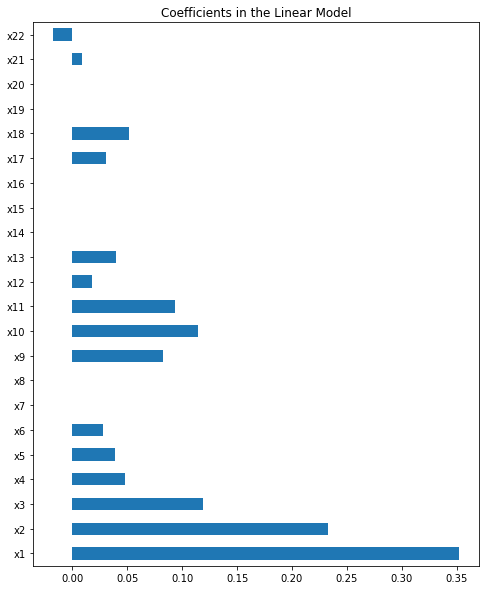

Sum of coefficients: 1.2754243616068603
Sum square of coefficients: 0.23119115232206636


In [210]:
coef = pd.Series(results_en.params)
rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()
print('Sum of coefficients: {}\nSum square of coefficients: {}'.format(sum(abs(results_en.params)), sum(map(lambda x:x*x,results_en.params))
))
